In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
import functions as fn
from collections import defaultdict
import os


In [2]:
species = "Nmel"
bioreps = ['F1', 'F2', 'F3']

chr1_test = False
qval_threshold = 1 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 2
genrich_area_threshold = 20
min_interval_size = 200
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping

kmer_size = 249 # size of kmers to sample from under peaks data
step_size = 100 # how much to slide kmer window by as you sample from under peaks data
overhang_thresh = 100 # stop sampling kmer windows if it is outside the peak interval by this many bp


In [3]:
wd = f"/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/{species}"

# load MACS peak files
macs_peaks_files = fn.get_files(f'{wd}/MACS2', "*_peaks.narrowPeak")
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

# load Genrich peak files
genrich_peaks_files = fn.get_files(f'{wd}/genrich_single', "*_peaks.narrowPeak")
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)
genrich_multi_peak_file = fn.get_files(f'{wd}/genrich_multi', "*_peaks.narrowPeak")[0]
genrich_pileup_files = fn.get_files(f'{wd}/genrich_single', "*_pileups.txt")

# load repeatmodeler intervals
repeat_file = f'/Genomics/kocherlab/bjarnold/STARRseq/data/repeat_modeler_intervals/{species}_repeat_elements.bed'

ref_genome = f'/Genomics/kocherlab/bjarnold/STARRseq/data/alternate_references/renamed/{species}.fasta'

print(macs_peaks_files)
print(genrich_peaks_files)
print(genrich_pileup_files)

['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/MACS2/Nmel-F3_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/MACS2/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/MACS2/Nmel-F1_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/genrich_single/Nmel-F3_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/genrich_single/Nmel-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/genrich_single/Nmel-F1_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/genrich_single/Nmel-F1_pileups.txt', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/genrich_single/Nmel-F3_pileups.txt', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling/Nmel/genrich_single/Nmel-F2_pileups.txt']


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [4]:
pileup_dfs = fn.load_genrich_pileup_files(genrich_pileup_files, chr1_test=chr1_test)
# these files contain NA's if an exclude list is used! For any region/interval in the exclude list, 0's will be reported in experiment and control columns, and
# NA will be reported in in the -log(p) column

In [5]:
macs_dfs = fn.load_peak_caller_results(macs_peaks_files, chr1_test) # list of macs dataframes
genrich_dfs = fn.load_peak_caller_results(genrich_peaks_files, chr1_test) # list of genrich dataframes
genrich_multi_df = fn.load_peak_caller_results([genrich_multi_peak_file], chr1_test)[0]

# FILTER PEAK FILES BY SIGNIFICANCE, EFFECT SIZE
print('MACS')
macs_dfs = fn.filter_by_sig_effect_size(macs_dfs, qval_threshold, macs_folddiff_threshold)
print('Genrich')
genrich_dfs = fn.filter_by_sig_effect_size(genrich_dfs, qval_threshold, genrich_area_threshold)

print([len(df) for df in macs_dfs])



MACS
before filtering: 104844
after filtering: 36205
before filtering: 101929
after filtering: 31722
before filtering: 103314
after filtering: 34128
Genrich
before filtering: 134246
after filtering: 40119
before filtering: 121542
after filtering: 29869
before filtering: 132922
after filtering: 46182
[36205, 31722, 34128]


In [6]:
# can't read with pandas because variable number of columns; some rows marked with an asterisk if the repeat overlaps with another higher-scoring repeat
# load by reading in all lines instead, then importing into table
# then use pyranges to merge overlapping intervals
repeat_pr = fn.load_repeat_modeler_intervals(repeat_file)


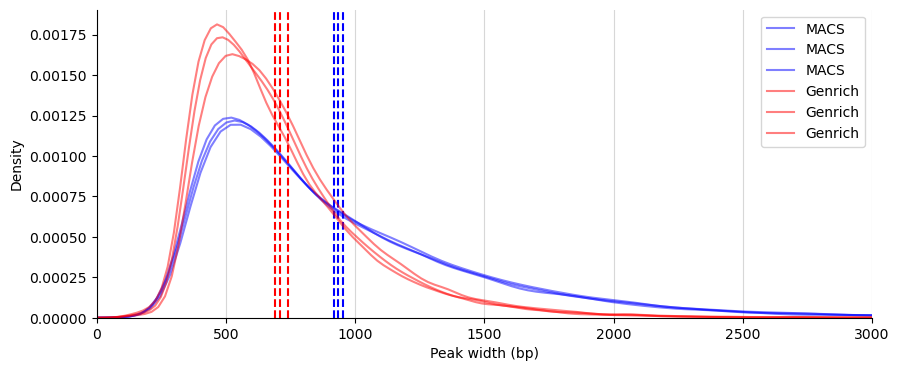

In [7]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="MACS")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in genrich_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="Genrich")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")
axs.set_ylabel("Density")
axs.grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
sns.despine()


# Compare MACS2 and Genrich within biological replicates, where we expect results to be the same

In [8]:
for m in macs_dfs:
    # convert peak/summit coordinate into an interval to overlap with pyranges
    m['peak_coord_1'] = m['peak_coord'] + 1

# gather relevant columns, put in new list of dataframes
macs_summit_dfs = [m[['Chromosome', 'peak_coord', 'peak_coord_1', 'signalValue']] for m in macs_dfs]

# rename columns to match pyranges format
for m in macs_summit_dfs:
    m.columns = ['Chromosome', 'Start', 'End', 'signalValue']

# convert df to pyranges object
macs_summit_prs = [pr.PyRanges(m) for m in macs_summit_dfs]
pileup_prs = [pr.PyRanges(p) for p in pileup_dfs]

# overlap macs peaks with genrich pileups
macs_with_pileup_dfs = []
for p,m in zip(pileup_prs, macs_summit_prs):
    # if you exclude regions in Genrich, need to do 'inner' join or None
    # previously you doing a right join since without exclude regions, we expected all macs peaks coords 
    # to overlap with a genrich pileup coord
    macs_with_pileup_dfs.append( p.join(m, how=None).df )



In [9]:
for m in macs_with_pileup_dfs:
    print(np.corrcoef(m.fold_diff, m.signalValue))

[[1.         0.91955937]
 [0.91955937 1.        ]]
[[1.         0.92977034]
 [0.92977034 1.        ]]
[[1.         0.93906943]
 [0.93906943 1.        ]]


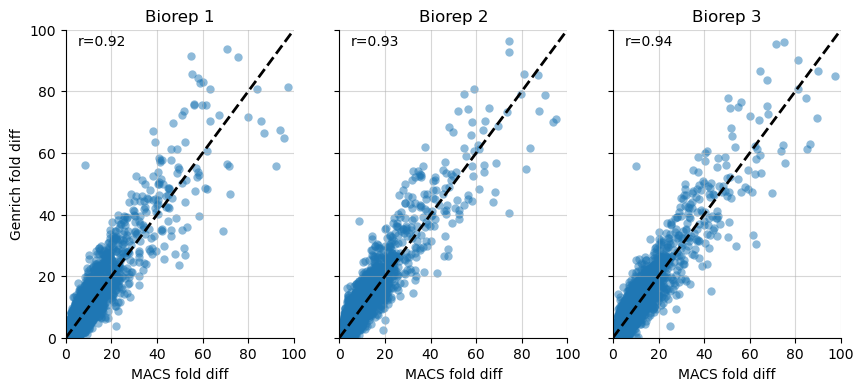

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,m in enumerate(macs_with_pileup_dfs):
    sns.scatterplot(x=m.signalValue, y=m.fold_diff, ax=axs[i], linewidth=0, alpha=0.5)
    axs[i].set_title(f"Biorep {i+1}")
    axs[i].set_xlabel("MACS fold diff")
    axs[i].set_ylabel("Genrich fold diff")    
    axs[i].set_xlim(0,100)
    axs[i].set_ylim(0,100)
    axs[i].plot([0, 100], [0, 100], linewidth=2, color='black', linestyle='--')
    # add grid lines
    axs[i].grid(True, alpha=0.5)
    # add correlation coefficient in plot
    corr = np.corrcoef(m.fold_diff, m.signalValue)[0,1]
    axs[i].text(0.05, 0.95, f"r={corr:.2f}", transform=axs[i].transAxes)

sns.despine()

# COMPARE PEAKS by overlapping intervals

In [11]:

# look at concordance of peak calling between methods, witihin bioreps
macs_peaks_overlaps, genrich_peaks_overlaps = fn.get_peak_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)
for i,m in enumerate(macs_peaks_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_peaks_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# fraction of overlap can seem odd if one caller has smaller peaks that are contained within a larger peak from the other caller

[(36205, 0.8321778759839801), (31722, 0.7682050312086249), (34128, 0.8807430848570089)]
[(40119, 0.88546573942521), (29869, 0.9691318758579129), (46182, 0.7707115326317613)]
MACS2: 36205 peaks, 83.22% overlap with Genrich peaks
MACS2: 31722 peaks, 76.82% overlap with Genrich peaks
MACS2: 34128 peaks, 88.07% overlap with Genrich peaks
Genrich: 40119 peaks, 88.55% overlap with MACS2 peaks
Genrich: 29869 peaks, 96.91% overlap with MACS2 peaks
Genrich: 46182 peaks, 77.07% overlap with MACS2 peaks


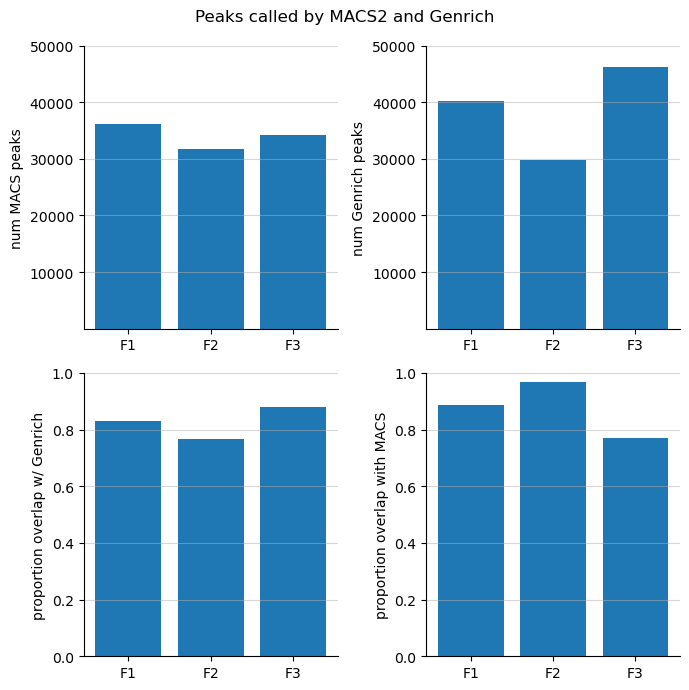

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharex=False, sharey=False)
t = range(len(macs_peaks_overlaps))
axs[0][0].bar(t, [m[0] for m in macs_peaks_overlaps])
axs[0][0].set_ylabel("num MACS peaks")
axs[0][0].set_xticks(t)
axs[0][0].set_yticks([10000, 20000, 30000, 40000, 50000])
axs[0][0].set_xticklabels(bioreps)
axs[0][0].grid(axis='y', alpha=0.5)

axs[0][1].bar(t, [g[0] for g in genrich_peaks_overlaps])
axs[0][1].set_ylabel("num Genrich peaks")
axs[0][1].set_xticks(t)
axs[0][1].set_yticks([10000, 20000, 30000, 40000, 50000])
axs[0][1].set_xticklabels(bioreps)
axs[0][1].grid(axis='y', alpha=0.5)


axs[1][0].bar(t, [m[1] for m in macs_peaks_overlaps])
axs[1][0].set_ylim(0,1)
axs[1][0].set_ylabel("proportion overlap w/ Genrich")
axs[1][0].set_xticks(t)
axs[1][0].set_xticklabels(bioreps)
axs[1][0].grid(axis='y', alpha=0.5)



axs[1][1].bar(t, [g[1] for g in genrich_peaks_overlaps])
axs[1][1].set_ylim(0,1)
axs[1][1].set_ylabel("proportion overlap with MACS")
axs[1][1].set_xticks(t)
axs[1][1].set_xticklabels(bioreps)
axs[1][1].grid(axis='y', alpha=0.5)

fig.suptitle("Peaks called by MACS2 and Genrich")


sns.despine()
plt.tight_layout()

# Compare MACS and Genrich between biological replicates

In [13]:
# look at overlaps within methods between bioreps
macs_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_dfs, bioreps, frac_overlap)
genrich_peaks_overlaps = fn.get_peak_overlaps_within_method_between_reps(genrich_dfs, bioreps, frac_overlap)

print(macs_peaks_overlaps)
print(genrich_peaks_overlaps)

[(36205, 31722, 11774), (36205, 34128, 11828), (31722, 34128, 11593)]
[(40119, 29869, 11040), (40119, 46182, 13151), (29869, 46182, 11965)]


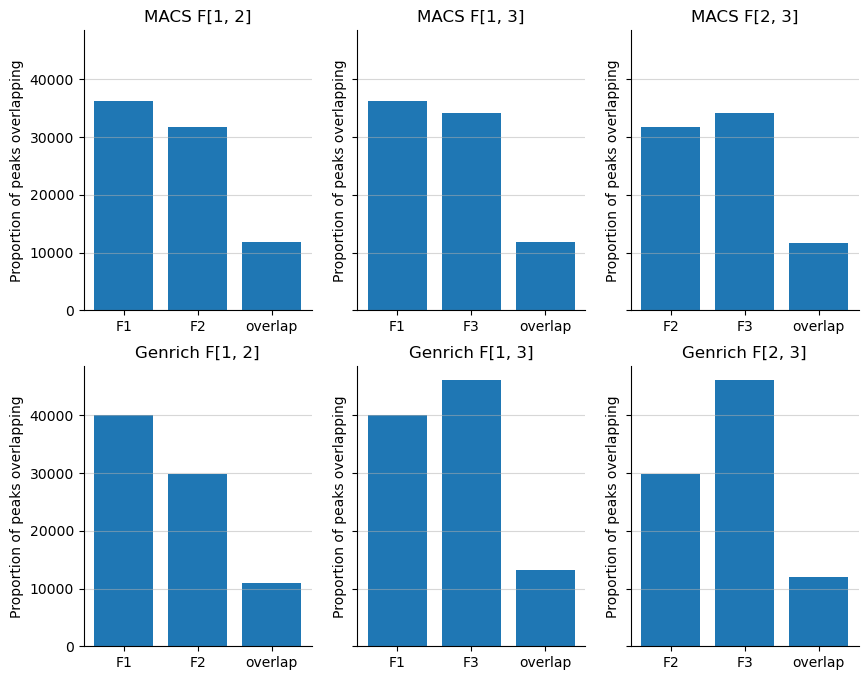

In [14]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_peaks_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[0][i].bar(range(len(comp)), comp)
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_peaks_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[1][i].bar(range(len(comp)), comp)
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

In [15]:
# convert each df to a pyranges object, count overlaps among biological replicates

genrich_overlaps_per_rep = fn.overlaps_per_replicate(genrich_dfs)
macs_overlaps_per_rep = fn.overlaps_per_replicate(macs_dfs)
# it looks like count_overlaps is counting overlaps b/t all instervals
# if all three replicates have an overlapping interval, pattern could look like this:
#       Chromosome	Start	End	    p1	p2	p3
# 7	    NMEL_chr_1	9079	9297	0	0	0
# 8	    NMEL_chr_1	9297	9309	1	0	0
# 9	    NMEL_chr_1	9309	9649	1	1	0
# 10	NMEL_chr_1	9649	10150	1	1	1
# 11	NMEL_chr_1	10150	10843	0	1	1
# 12	NMEL_chr_1	10843	10914	0	0	1
# 13	NMEL_chr_1	10914	16276	0	0	0
# where index 10 is interval in which all 3 peaks are overlapping, but since start/end points of the peaksare different,
# we can see that replicate 1 has the minimum starting point, and replicate 3 has the maximum ending point

macs_overlaps_per_rep.head()

,Chromosome,Start,End,p1,p2,p3,combined
0,NMEL_chr_1,434,464,0,1,0,010
1,NMEL_chr_1,464,963,0,1,1,011
2,NMEL_chr_1,963,993,0,1,0,010
3,NMEL_chr_1,993,1825,0,0,0,000
4,NMEL_chr_1,1825,2412,1,0,0,100


In [16]:
genrich_overlaps_per_rep['Chromosome'].unique()
len(genrich_overlaps_per_rep[genrich_overlaps_per_rep['combined'] == '111'])

9801

In [17]:
def get_triplet_peaks(overlaps_df, min_interval_size, method):
    trips_df = overlaps_df[(overlaps_df['End']-overlaps_df['Start'] > min_interval_size) & 
                            (overlaps_df['combined'] == '111')]                          
    trips_df['method'] = method
    return trips_df
    
genrich_trips_df = get_triplet_peaks(genrich_overlaps_per_rep, min_interval_size, 'genrich')
macs_trips_df = get_triplet_peaks(macs_overlaps_per_rep, min_interval_size, 'macs')

print(len(genrich_trips_df))
print(len(macs_trips_df))

8950
9731


/tmp/ipykernel_1120968/728894939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df['method'] = method
/tmp/ipykernel_1120968/728894939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df['method'] = method


In [18]:
# make a single dataframe trips_df that contains all Genrich peaks supported by all 3 replicates
# as well as MACS peaks supported by all 3 replicates that were not detected by Genrich

m = pr.PyRanges(chromosomes=macs_trips_df.Chromosome,
                starts=macs_trips_df.Start,
                ends=macs_trips_df.End)
g = pr.PyRanges(chromosomes=genrich_trips_df.Chromosome,
                starts=genrich_trips_df.Start,
                ends=genrich_trips_df.End)
# use coverage to find overlaps, covert to dataframe to filter those with at least frac_overlap overlap
m_cov = m.coverage(g, overlap_col="C", fraction_col="F").df
g_cov = g.coverage(m, overlap_col="C", fraction_col="F").df

# get all indices of m_cov in which 'C' columns == 0, i.e. not detected at all by Genrich
m_cov_indices = m_cov.index[m_cov['C']==0].tolist()
m_cov.iloc[m_cov_indices]
trips_df = pd.concat([genrich_trips_df, macs_trips_df.iloc[m_cov_indices]], axis=0)

trips_df.sort_values(by=['Chromosome', 'Start'], inplace=True)
trips_df = trips_df.reset_index(drop=True)
trips_df['trip_id'] = trips_df.index
print(trips_df.groupby('method').count())
trips_df

         Chromosome  Start   End    p1    p2    p3  combined  trip_id
method                                                               
genrich        8950   8950  8950  8950  8950  8950      8950     8950
macs           1778   1778  1778  1778  1778  1778      1778     1778


,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id
0,NMEL_chr_1,9649,10150,1,1,1,111,genrich,0
1,NMEL_chr_1,46160,47070,1,1,1,111,genrich,1
2,NMEL_chr_1,52280,52740,1,1,1,111,macs,2
3,NMEL_chr_1,78398,79369,1,1,1,111,genrich,3
4,NMEL_chr_1,82392,82949,1,1,1,111,genrich,4
...,...,...,...,...,...,...,...,...,...
10723,NMEL_unplaced_97,1767,2088,1,1,1,111,macs,10723
10724,NMEL_unplaced_973,964,1244,1,1,1,111,genrich,10724
10725,NMEL_unplaced_983,568,1271,1,1,1,111,genrich,10725
10726,NMEL_unplaced_993,882,1287,1,1,1,111,macs,10726


6322576
589.3527218493662


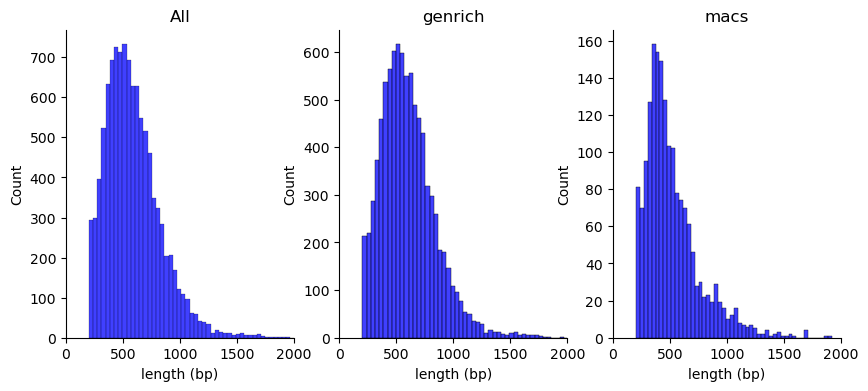

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=False)
print(np.sum(trips_df['End'] - trips_df['Start']))
print(np.mean(trips_df['End'] - trips_df['Start']))

sns.histplot(trips_df['End'] - trips_df['Start'], bins=100, color="blue", ax=axs[0])
axs[0].set_title("All")
axs[0].set_xlabel("length (bp)")
axs[0].set_xlim(0,2000)
sns.histplot(trips_df['End'][trips_df['method']=='genrich'] - trips_df['Start'][trips_df['method']=='genrich'], bins=100, color="blue", ax=axs[1])
axs[1].set_title("genrich")
axs[1].set_xlabel("length (bp)")
sns.histplot(trips_df['End'][trips_df['method']=='macs'] - trips_df['Start'][trips_df['method']=='macs'], bins=50, color="blue", ax=axs[2])
axs[2].set_title("macs")
axs[2].set_xlabel("length (bp)")


sns.despine()

In [20]:
# convert dataframes into pyranges for overlapping
# trips_pr = pr.PyRanges(trips_df.head(10))
trips_pr = pr.PyRanges(trips_df)
pile1 = pr.PyRanges(pileup_dfs[0])
pile2 = pr.PyRanges(pileup_dfs[1])
pile3 = pr.PyRanges(pileup_dfs[2])



In [21]:

pile1_trips = pile1.join(trips_pr, report_overlap=True, how='right')
pile2_trips = pile2.join(trips_pr, report_overlap=True, how='right')
pile3_trips = pile3.join(trips_pr, report_overlap=True, how='right')

pile1_trips = pile1_trips.df
pile2_trips = pile2_trips.df
pile3_trips = pile3_trips.df


In [22]:
print(pile1_trips.shape)
print(pile2_trips.shape)
print(pile3_trips.shape)

(400758, 18)
(388987, 18)
(425630, 18)


In [31]:
# for each trip_id in each replicate, get average fold diff wtihin each interval, weighted by number of bases in pileup
f_wavg = lambda x: np.average(x.fold_diff, weights=x.bases)
f_summit = lambda x: x.midpoint[x.fold_diff == np.max(x.fold_diff)].values[0]

pile1_trips_wavgs = pile1_trips.groupby('trip_id').apply(f_wavg)
pile2_trips_wavgs = pile2_trips.groupby('trip_id').apply(f_wavg)
pile3_trips_wavgs = pile3_trips.groupby('trip_id').apply(f_wavg)
wavg = np.column_stack((pile1_trips_wavgs,
                    pile2_trips_wavgs,
                    pile3_trips_wavgs))


pile1_trips_summits = pile1_trips.groupby('trip_id').apply(f_summit)
pile2_trips_summits = pile2_trips.groupby('trip_id').apply(f_summit)
pile3_trips_summits = pile3_trips.groupby('trip_id').apply(f_summit)

# filter out rows of wavg with any 0 values
print(np.sum(np.any(wavg == 0, axis=1)), "peaks had at least 1 replicate with 0-fold difference")
print(np.sum(np.any(wavg < 0, axis=1)), "peaks had at least 1 replicate with negative difference")
wavg = wavg[(~np.any(wavg == 0, axis=1)) & (~np.any(wavg < 0, axis=1))]

print(wavg.shape)
print(np.corrcoef(wavg, rowvar=False))



0 peaks had at least 1 replicate with 0-fold difference
0 peaks had at least 1 replicate with negative difference
(10728, 3)
[[1.         0.93340271 0.94115789]
 [0.93340271 1.         0.93925884]
 [0.94115789 0.93925884 1.        ]]


In [ ]:
pile1_trips_summits

In [ ]:
trips_df["F1_wavg"] = pile1_trips_wavgs
trips_df["F2_wavg"] = pile2_trips_wavgs
trips_df["F3_wavg"] = pile3_trips_wavgs

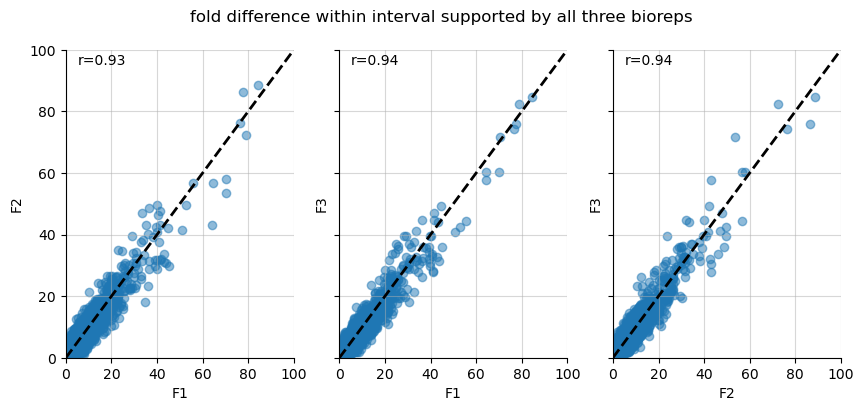

In [ ]:
combos = list(itertools.combinations(range(wavg.shape[1]), 2))
combos

fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for i,combo in enumerate(combos):
    axs[i].scatter(wavg[:,combo[0]], wavg[:,combo[1]], alpha=0.5)
    axs[i].set_xlabel(f"F{combo[0]+1}")
    axs[i].set_ylabel(f"F{combo[1]+1}")
    axs[i].set_xlim(0,100)
    axs[i].set_ylim(0,100)
    axs[i].plot([0, 100], [0, 100], linewidth=2, color='black', linestyle='--')
    # add grid lines
    axs[i].grid(True, alpha=0.5)
    # add correlation coefficient in plot
    corr = np.corrcoef(wavg[:,combo[0]], wavg[:,combo[1]])[0,1]
    axs[i].text(0.05, 0.95, f"r={corr:.2f}", transform=axs[i].transAxes)
fig.suptitle("fold difference within interval supported by all three bioreps")
sns.despine()

medians: [2.70809965 2.69945935 2.75395395]
means: [3.88293745 3.84168718 3.86396858]
variances: [19.85309337 19.1900736  19.51831528]
means of logged: [0.48430923 0.48171877 0.48727796]
variances of logged: [0.06830281 0.0674624  0.06507857]


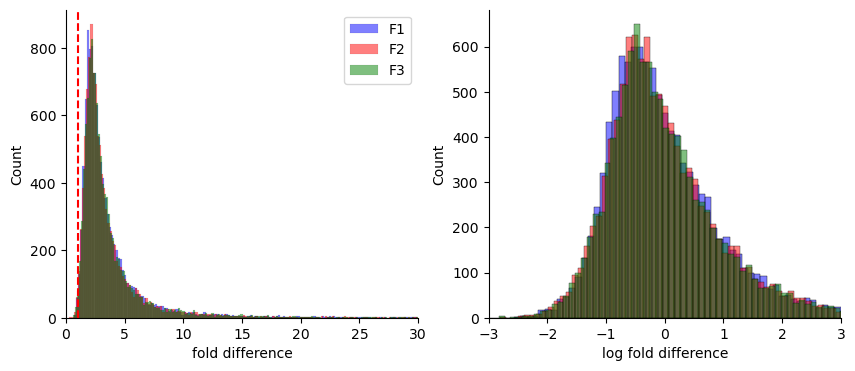

In [ ]:
# are there systematic differences in fold differences across replicates?
print("medians:", np.median(wavg, axis=0))
print("means:", np.mean(wavg, axis=0))
print("variances:", np.var(wavg, axis=0))
print("means of logged:", np.mean(np.log10(wavg), axis=0))
print("variances of logged:", np.var(np.log10(wavg), axis=0))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(wavg[:,0], color="blue", alpha=0.5, label="F1", ax=axs[0])
sns.histplot(wavg[:,1], color="red", alpha=0.5, label="F2", ax=axs[0])
sns.histplot(wavg[:,2], color="green", alpha=0.5, label="F3", ax=axs[0])
axs[0].axvline(x=1, color='red', linestyle='--')
axs[0].set_xlim(0,30)
axs[0].set_xlabel("fold difference")
axs[0].legend()

wavg_norm = (np.log10(wavg) - np.mean(np.log10(wavg), axis=0)) / np.std(np.log10(wavg), axis=0)
# wavg_norm = (np.log10(wavg) - np.mean(np.log10(wavg), axis=0)) / (np.max(np.log10(wavg), axis=0) - np.min(np.log10(wavg), axis=0))

# wavg_norm = (wavg - np.mean(wavg, axis=0)) / np.std(wavg, axis=0)

sns.histplot((wavg_norm[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[1])
sns.histplot((wavg_norm[:,1]), color="red", alpha=0.5, label="F2", ax=axs[1])
sns.histplot((wavg_norm[:,2]), color="green", alpha=0.5, label="F3", ax=axs[1])
# sns.histplot(np.log10(wavg[:,0]), color="blue", alpha=0.5, label="F1", ax=axs[1])
# sns.histplot(np.log10(wavg[:,1]), color="red", alpha=0.5, label="F2", ax=axs[1])
# sns.histplot(np.log10(wavg[:,2]), color="green", alpha=0.5, label="F3", ax=axs[1])
axs[1].set_xlim(-3,3)
axs[1].set_xlabel("log fold difference")

sns.despine()


# look at specific triplet interval

    Chromosome   Start     End p1 p2 p3 combined method trip_id   F1_wavg  \
18  NMEL_chr_1  381847  382508  1  1  1      111   macs      18  1.893347   

     F2_wavg   F3_wavg  
18  1.430653  0.967575  


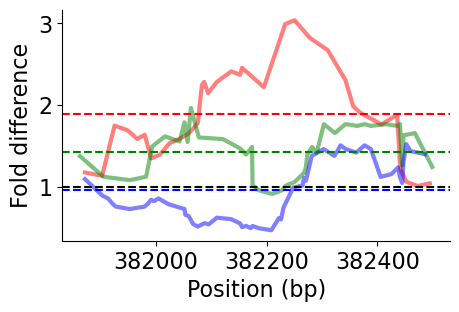

In [ ]:
# NOTE: USED MACS THRESHOLD OF FOLD DIFFERENCE, BUT REPORTED FOLD DIFFERENCE REPORTED HERE IS FROM GENRICH SO COULD BE DIFFERENT
i = 18
tmp = pd.DataFrame(trips_df.iloc[i]).T
print(tmp)
candidate_trip_pr = pr.PyRanges(chromosomes=tmp.Chromosome,
                starts=tmp.Start,
                ends=tmp.End)

fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
colors = ['red', 'green', 'blue']
for i,p in enumerate([pile1, pile2, pile3]):
    candidate_trip_pile = candidate_trip_pr.join(p, report_overlap=True, how='left')
    sns.lineplot(x=candidate_trip_pile.midpoint, y=candidate_trip_pile.fold_diff, linewidth=3, alpha=0.5, color=colors[i])

plt.axhline(y=tmp.F1_wavg.iloc[0], color=colors[0], linestyle='--')
plt.axhline(y=tmp.F2_wavg.iloc[0], color=colors[1], linestyle='--')
plt.axhline(y=tmp.F3_wavg.iloc[0], color=colors[2], linestyle='--')



# increase font sizes
axs.set_xlabel("Position (bp)", fontsize=16)
axs.set_ylabel("Fold difference", fontsize=16)
# increase x and y axes font size
axs.tick_params(axis='both', which='major', labelsize=16)
plt.axhline(y=1, color='black', linestyle='--')
sns.despine()


In [ ]:
trips_df.head(20)

,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id,F1_wavg,F2_wavg,F3_wavg
0,NMEL_chr_1,9649,10150,1,1,1,111,genrich,0,7.653426,3.773312,6.062075
1,NMEL_chr_1,46160,47070,1,1,1,111,genrich,1,8.520988,6.534773,8.494230
2,NMEL_chr_1,52280,52740,1,1,1,111,macs,2,3.043996,1.403878,1.839689
3,NMEL_chr_1,78398,79369,1,1,1,111,genrich,3,5.105457,5.803104,3.224901
4,NMEL_chr_1,82392,82949,1,1,1,111,genrich,4,2.597311,2.133922,1.644103
5,NMEL_chr_1,176912,177545,1,1,1,111,genrich,5,4.390158,5.312823,4.764669
6,NMEL_chr_1,203685,204209,1,1,1,111,macs,6,1.684265,3.258425,1.309889
7,NMEL_chr_1,212031,212276,1,1,1,111,macs,7,1.307696,1.711384,1.571358
8,NMEL_chr_1,251178,251866,1,1,1,111,genrich,8,4.437663,4.103617,4.616224
9,NMEL_chr_1,276152,276952,1,1,1,111,genrich,9,4.184985,2.701366,2.592295


In [ ]:
# for each peak, find summit within each biological replicate


In [ ]:
tmp = pd.DataFrame(trips_df.iloc[0])
# transspose x so that row names are column names
tmp = tmp.T
tmp

,Chromosome,Start,End,p1,p2,p3,combined,method,trip_id,F1_wavg,F2_wavg,F3_wavg
0,NMEL_chr_1,9649,10150,1,1,1,111,genrich,0,7.653426,3.773312,6.062075


In [ ]:
candidate_trip_df[candidate_trip_df['combined'] == '111']
#  df = df[df['combined'].isin(support_patterns)]

NameError: name 'candidate_trip_df' is not defined

In [ ]:
num_points = 833/100
833/num_points

100.0

In [ ]:
stop

NameError: name 'stop' is not defined

# APPENDIX

In [ ]:
# THIS SECTION IS A LITTLE COMPLICATED AND MAY BE REPLACED BY A FUNCTION THAT SIMPLY IDENTIFIES INTERVALS WITH PEAKS SUPPORTED BY 1, 2, OR 3 REPLICATES
# CURRENTLY IT USES INTERVALS WITH NO PEAKS AS LANDMARKS TO IDENTIFY INTERVALS WITH PEAKS SUPPORTED BY 1, 2, OR 3 REPLICATES, BECAUSE I WAS ORIGINALLY 
# THINKING OF USING THESE ENTIRE META INTERVALS IF THEY CONTAINED AT LEAST ONE SUBINTERVAL WITH SUPPORT FROM 3 REPLICATES.

def check_singleton(candidate):
    x = ['100', '010', '001']
    string = candidate['combined'].to_string(index=False)
    try:
        # return index of matching string
        return x.index(string)
    except ValueError:
        return -1

def categorize_support_from_overlaps_df(overlaps_per_rep):
    """
    This function goes through overlaps_per_rep, finds intervals with no peaks, and uses these intervals as landmarks.
    Between these intervals with no peaks are intervals with peaks supported by 1, 2, or 3 replicates, where support 
    can vary. intervals_with_triplet_peaks contains intervals with peaks supported by 3 replicates.
    """

    singleton_peaks = defaultdict(int) # peaks only supported by a single caller
    doublet_peaks = [] # peaks supported by 2 callers with some interval overlap
    intervals_with_triplet_peaks = [] # peaks supported by 3 callers with some interval overlap
    adjacent_nonoverlapping_peaks = 0
    for chrom in overlaps_per_rep['Chromosome'].unique():
        # look only at specific chromosomes to avoid comparing comparing peak callers at chromosome endpoints
        df = overlaps_per_rep[overlaps_per_rep['Chromosome'] == chrom]
        df.reset_index(inplace=True, drop=False) # keep index in case useful for later
        # get candidate intervals using indices in which there's an interval with no peaks
        # these can then be parsed into intervals supported by 1, 2, or 3 replicates
        indices = np.array(df.index[df['combined'] == '000'])
        # print(indices)
        
        for i in range(len(indices)-1):
            # first deal with singleton regions, or single intervals flanked by regions of no peaks
            if indices[i+1] - indices[i] == 2:
                # candidate singleton, a 100, 010, or 001 flanked by 000
                candidate_singleton = df.iloc[[indices[i]+1]]
                singleton_type = check_singleton(candidate_singleton)
                if singleton_type != -1:
                    singleton_peaks[singleton_type] += 1
                else:
                    support_patterns = candidate_singleton['combined'].unique()
                    if '111' in support_patterns:
                        intervals_with_triplet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])
                    elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                        doublet_peaks.append([np.min(candidate_singleton['index']), np.max(candidate_singleton['index'])])  
                    else:
                        print('candidate singleton error')      
            # second deal with larger candidate regions, containing intervals with support from 2+ replicates
            # although rarely, some of these regions contain intervals with only support from 1 replicate with
            # immediately adjacent endpoints
            elif indices[i+1] - indices[i] > 2:
                #multiple intervals involving more than 1 bioreplicate
                candidate_interval_df = df.iloc[list(range(indices[i]+1,indices[i+1]))]
                support_patterns = candidate_interval_df['combined'].unique()
                if '111' in support_patterns:
                    intervals_with_triplet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                elif '110' in support_patterns or '101' in support_patterns or '011' in support_patterns:
                    doublet_peaks.append([np.min(candidate_interval_df['index']), np.max(candidate_interval_df['index'])])
                else:
                    adjacent_nonoverlapping_peaks += 1
            else:
                print("error")
    print("adjacent_nonoverlapping_peaks: ", adjacent_nonoverlapping_peaks)
    return singleton_peaks, doublet_peaks, intervals_with_triplet_peaks

intervals_with_triplet_peaks = defaultdict(list)
singleton_peaks, doublet_peaks, intervals_with_triplet_peaks['genrich'] = categorize_support_from_overlaps_df(genrich_overlaps_per_rep)
singleton_peaks, doublet_peaks, intervals_with_triplet_peaks['macs'] = categorize_support_from_overlaps_df(macs_overlaps_per_rep)

print(singleton_peaks)
print(len(doublet_peaks))
print(len(intervals_with_triplet_peaks['genrich']))
print(doublet_peaks[0:20])
print(intervals_with_triplet_peaks['genrich'][0:20])
# for each interval containing support by three replicates, how many separate subintervals contain support by all 3?
summary = defaultdict(int)
for t in intervals_with_triplet_peaks['genrich']:
    df = genrich_overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    if len(df) == 4:
        print(t)
        print(genrich_overlaps_per_rep.iloc[list(range(t[0]-1, t[1]+2))])
    summary[len(df)] += 1
summary
# DOUBLE CHECK THIS, WHAT HAPPENS WHEN MULTIPLE 111 CATEGORY FOR PARTICULAR INTERVAL
# ACCOUNT FOR WITH TRIP_ID?

def get_triplet_peak_coords(triplet_peaks, overlaps_per_rep, min_interval_size, method):
    # make a dataframe containing all subintervals supported by all 3 replicates
    trips_indices = [list(range(t[0],t[1]+1)) for t in triplet_peaks] # for each interval containing a triplet, get list of indices contianing all subintervals
    trips_df = pd.DataFrame()
    support_patterns = ['111']
    # support_patterns = ['111', '110', '101', '011']

    for i,t in enumerate(trips_indices):
        df = overlaps_per_rep.iloc[t]
        # within interval, grab out subinterval actually supported by all 3 replicates
        #df = df[df['combined'] == '111']
        df = df[df['combined'].isin(support_patterns)]
        # df['trip_id'] = i
        if not trips_df.empty:
            trips_df = pd.concat([trips_df, df], axis=0)
        else:
            trips_df = df

    trips_df = trips_df[trips_df['End'] - trips_df['Start'] > min_interval_size]
    trips_df.reset_index(inplace=True, drop=True)
    trips_df['trip_id'] = trips_df.index # each subinterval supported by all 3 replicates gets a unique trip_id, even if they were part of the same series of overlapping intervals among 3 replicates
    trips_df['midpoint_start'] = (trips_df['End'] - trips_df['Start'])/2 + trips_df['Start']
    trips_df['midpoint_start'] = trips_df['midpoint_start'].astype(int)
    trips_df['midpoint_end'] = trips_df['midpoint_start']+1
    trips_df['method'] = method
    # assert len(trips_df['combined'].unique()) == 1 and trips_df['combined'].unique()[0] == '111'
    trips_df = trips_df[['Chromosome', 'Start', 'End', 'trip_id', 'midpoint_start', 'midpoint_end', 'method']]
    # print(trips_df)
    print("number of intervals:", len(trips_df))
    print(len(trips_indices))
    return(trips_df)

genrich_trips_df = get_triplet_peak_coords(intervals_with_triplet_peaks['genrich'], genrich_overlaps_per_rep, min_interval_size, 'genrich')
macs_trips_df = get_triplet_peak_coords(intervals_with_triplet_peaks['macs'], macs_overlaps_per_rep, min_interval_size, 'macs')

# COMPARE SUMMITS (NOT PEAKS, WHICH IS THE ENTIRE INTERVAL CALLED BY METHOD)

In [ ]:

# look at overlaps between methods within bioreps
macs_summit_overlaps, genrich_summit_overlaps = fn.get_summit_overlaps_between_method_within_reps(macs_dfs, genrich_dfs, dist_thresh)
print(macs_summit_overlaps)
print(genrich_summit_overlaps)
for i,m in enumerate(macs_summit_overlaps):
    print(f"MACS2: {m[0]} peaks, {m[1]*100:.2f}% overlap with Genrich peaks")
for i,m in enumerate(genrich_summit_overlaps):
    print(f"Genrich: {m[0]} peaks, {m[1]*100:.2f}% overlap with MACS2 peaks")

# look at overlaps within methods between bioreps
macs_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(macs_dfs, bioreps, dist_thresh)
genrich_summit_overlaps = fn.get_summit_overlaps_within_method_between_reps(genrich_dfs, bioreps, dist_thresh)

print(macs_summit_overlaps)
print(genrich_summit_overlaps)

: 

In [ ]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=True)
for i,comp in enumerate(macs_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[0][i].bar(range(len(comp)), comp, color="blue")
    axs[0][i].set_title(f"MACS F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(genrich_summit_overlaps):
    rep = biorep_comb[i]
    # print(rep[0], rep[1])
    l = [f"F{rep[0]}", f"F{rep[1]}", "comp"]
    axs[1][i].bar(range(len(comp)), comp, color="blue")
    axs[1][i].set_title(f"Genrich F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()

: 

: 

: 

In [ ]:
maxs = []
means = []

# pile1 = pr.PyRanges(pileup_dfs[0])
# pile2 = pr.PyRanges(pileup_dfs[1])
# pile3 = pr.PyRanges(pileup_dfs[2])

for t in triplet_peaks[0:10]:
    df = overlaps_per_rep.iloc[list(range(t[0], t[1]+1))]
    # only grab intervals supported by all 3 replicates
    df = df[df['combined'] == '111']
    # CURRENTLY IGNORING INTERVALS WITH MULTIPLE INTERVALS OF SUPPORT FROM 3 REPLICATES
    if len(df) > 1:
        continue
    chrom = df['Chromosome'].unique()[0]

    p = pr.PyRanges(df)
    pile1 = pr.PyRanges(pileup_dfs[0][pileup_dfs[0]['Chromosome'] == chrom])
    pile2 = pr.PyRanges(pileup_dfs[1][pileup_dfs[1]['Chromosome'] == chrom])
    pile3 = pr.PyRanges(pileup_dfs[2][pileup_dfs[2]['Chromosome'] == chrom])    

    # pile1 = pr.PyRanges(pileup_dfs[0][(pileup_dfs[0]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[0]['Start'] >= np.min(df['Start'])) &
    #                                     (pileup_dfs[0]['End'] <= np.max(df['End']))])
    # pile2 = pr.PyRanges(pileup_dfs[1][(pileup_dfs[1]['Chromosome'] == chrom) & 
    #                                   (pileup_dfs[1]['Start'] >= np.min(df['Start'])) &
    #                                 (pileup_dfs[1]['End'] <= np.max(df['End']))])
    # pile3 = pr.PyRanges(pileup_dfs[2][(pileup_dfs[2]['Chromosome'] == chrom) &
    #                                   (pileup_dfs[2]['Start'] >= np.min(df['Start'])) &
    #                                   (pileup_dfs[2]['End'] <= np.max(df['End']))])    

    # print(df['End']-df['Start'])
    # df.head()
    fold_diffs = [np.array(pile1.overlap(p).fold_diff), 
                  np.array(pile2.overlap(p).fold_diff), 
                  np.array(pile3.overlap(p).fold_diff)]


    maxs.append([np.max(x) for x in fold_diffs])
    means.append([np.mean(x) for x in fold_diffs])



: 

In [ ]:
df


: 

In [ ]:
len(triplet_peaks)

: 

In [ ]:
# p1 = pr.PyRanges(genrich_dfs[0])
# p1 = pr.PyRanges(genrich_dfs[1])
# p1 = pr.PyRanges(genrich_dfs[2])
# gr = {"p1":p1, "p2":p2, "p3":p3}
# overlaps_per_rep = pr.count_overlaps(gr)


: 

In [ ]:
overlaps_per_rep

: 

In [ ]:
genrich_dfs[0]

: 

In [ ]:
print(p1.coverage(p2, overlap_col="C", fraction_col="F").head())
print(p1.coverage(p3, overlap_col="C", fraction_col="F").head())
print(p2.coverage(p3, overlap_col="C", fraction_col="F").head())



: 